In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
import sharppy.plot.skew as skew
import matplotlib.pyplot as plt
from sharppy.sharptab import winds, utils, params, thermo, interp, profile
from sharppy.io.spc_decoder import SPCDecoder
import xarray as xr
from metpy.calc import dewpoint_from_relative_humidity
import glob
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter, MultipleLocator
import pyart
import cartopy.crs as ccrs
import warnings; warnings.simplefilter("ignore")
import zipfile
from IPython.display import display, Markdown
import netCDF4 as nc
from sklearn.cluster import KMeans as kmeans
import seaborn as sns
import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes as inset
from matplotlib.patches import Circle


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#Code to register the "skewx" projection, from here https://matplotlib.org/stable/gallery/specialty_plots/skewt.html

from contextlib import ExitStack

from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
from matplotlib.projections import register_projection


# The sole purpose of this class is to look at the upper, lower, or total
# interval as appropriate and see what parts of the tick to draw, if any.
class SkewXTick(maxis.XTick):
    def draw(self, renderer):
        # When adding the callbacks with `stack.callback`, we fetch the current
        # visibility state of the artist with `get_visible`; the ExitStack will
        # restore these states (`set_visible`) at the end of the block (after
        # the draw).
        with ExitStack() as stack:
            for artist in [self.gridline, self.tick1line, self.tick2line,
                           self.label1, self.label2]:
                stack.callback(artist.set_visible, artist.get_visible())
            needs_lower = transforms.interval_contains(
                self.axes.lower_xlim, self.get_loc())
            needs_upper = transforms.interval_contains(
                self.axes.upper_xlim, self.get_loc())
            self.tick1line.set_visible(
                self.tick1line.get_visible() and needs_lower)
            self.label1.set_visible(
                self.label1.get_visible() and needs_lower)
            self.tick2line.set_visible(
                self.tick2line.get_visible() and needs_upper)
            self.label2.set_visible(
                self.label2.get_visible() and needs_upper)
            super().draw(renderer)

    def get_view_interval(self):
        return self.axes.xaxis.get_view_interval()


# This class exists to provide two separate sets of intervals to the tick,
# as well as create instances of the custom tick
class SkewXAxis(maxis.XAxis):
    def _get_tick(self, major):
        return SkewXTick(self.axes, None, major=major)

    def get_view_interval(self):
        return self.axes.upper_xlim[0], self.axes.lower_xlim[1]


# This class exists to calculate the separate data range of the
# upper X-axis and draw the spine there. It also provides this range
# to the X-axis artist for ticking and gridlines
class SkewSpine(mspines.Spine):
    def _adjust_location(self):
        pts = self._path.vertices
        if self.spine_type == 'top':
            pts[:, 0] = self.axes.upper_xlim
        else:
            pts[:, 0] = self.axes.lower_xlim


# This class handles registration of the skew-xaxes as a projection as well
# as setting up the appropriate transformations. It also overrides standard
# spines and axes instances as appropriate.
class SkewXAxes(Axes):
    # The projection must specify a name.  This will be used be the
    # user to select the projection, i.e. ``subplot(projection='skewx')``.
    name = 'skewx'

    def _init_axis(self):
        # Taken from Axes and modified to use our modified X-axis
        self.xaxis = SkewXAxis(self)
        self.spines.top.register_axis(self.xaxis)
        self.spines.bottom.register_axis(self.xaxis)
        self.yaxis = maxis.YAxis(self)
        self.spines.left.register_axis(self.yaxis)
        self.spines.right.register_axis(self.yaxis)

    def _gen_axes_spines(self):
        spines = {'top': SkewSpine.linear_spine(self, 'top'),
                  'bottom': mspines.Spine.linear_spine(self, 'bottom'),
                  'left': mspines.Spine.linear_spine(self, 'left'),
                  'right': mspines.Spine.linear_spine(self, 'right')}
        return spines

    def _set_lim_and_transforms(self):
        """
        This is called once when the plot is created to set up all the
        transforms for the data, text and grids.
        """
        rot = 30

        # Get the standard transform setup from the Axes base class
        super()._set_lim_and_transforms()

        # Need to put the skew in the middle, after the scale and limits,
        # but before the transAxes. This way, the skew is done in Axes
        # coordinates thus performing the transform around the proper origin
        # We keep the pre-transAxes transform around for other users, like the
        # spines for finding bounds
        self.transDataToAxes = (
            self.transScale
            + self.transLimits
            + transforms.Affine2D().skew_deg(rot, 0)
        )
        # Create the full transform from Data to Pixels
        self.transData = self.transDataToAxes + self.transAxes

        # Blended transforms like this need to have the skewing applied using
        # both axes, in axes coords like before.
        self._xaxis_transform = (
            transforms.blended_transform_factory(
                self.transScale + self.transLimits,
                transforms.IdentityTransform())
            + transforms.Affine2D().skew_deg(rot, 0)
            + self.transAxes
        )

    @property
    def lower_xlim(self):
        return self.axes.viewLim.intervalx

    @property
    def upper_xlim(self):
        pts = [[0., 1.], [1., 1.]]
        return self.transDataToAxes.inverted().transform(pts)[:, 0]


# Now register the projection with matplotlib so the user can select it.
register_projection(SkewXAxes)

In [6]:
def plot_sounding(time, lat, lon, plot=False):

    str_fmt = "/g/data/rt52/era5/pressure-levels/reanalysis/%s/%d/%s_era5_oper_pl_%s*.nc" 
    str_fmt_sfc = "/g/data/rt52/era5/single-levels/reanalysis/%s/%d/%s_era5_oper_sfc_%s*.nc"
    
    _, latlon = get_point_data(time,lat,lon,50,["mu_cape"],plot=False,vmin=None,vmax=None)
    lat = latlon[0]
    lon = latlon[1]
    
    z=xr.open_dataset(glob.glob(str_fmt % ("z",time.year,"z",time.strftime("%Y%m01")))[0])["z"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    t=xr.open_dataset(glob.glob(str_fmt % ("t",time.year,"t",time.strftime("%Y%m01")))[0])["t"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    r=xr.open_dataset(glob.glob(str_fmt % ("r",time.year,"r",time.strftime("%Y%m01")))[0])["r"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    u=xr.open_dataset(glob.glob(str_fmt % ("u",time.year,"u",time.strftime("%Y%m01")))[0])["u"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    v=xr.open_dataset(glob.glob(str_fmt % ("v",time.year,"v",time.strftime("%Y%m01")))[0])["v"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")

    ts=xr.open_dataset(glob.glob(str_fmt_sfc % ("2t",time.year,"2t",time.strftime("%Y%m01")))[0])["t2m"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    dps=xr.open_dataset(glob.glob(str_fmt_sfc % ("2d",time.year,"2d",time.strftime("%Y%m01")))[0])["d2m"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    us=xr.open_dataset(glob.glob(str_fmt_sfc % ("10u",time.year,"10u",time.strftime("%Y%m01")))[0])["u10"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    vs=xr.open_dataset(glob.glob(str_fmt_sfc % ("10v",time.year,"10v",time.strftime("%Y%m01")))[0])["v10"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    ps=xr.open_dataset(glob.glob(str_fmt_sfc % ("sp",time.year,"sp",time.strftime("%Y%m01")))[0])["sp"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    zs=xr.open_dataset(glob.glob(str_fmt_sfc % ("z",time.year,"z",time.strftime("%Y%m01")))[0])["z"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")   
    
    p=z.level
    dp=dewpoint_from_relative_humidity(t,r)
    prof_pres = np.flip(p.values.squeeze())
    prof_hgt = np.flip(z.values.squeeze()/9.8)
    prof_tmpc = np.flip(t.values.squeeze()-273.15)
    prof_dwpc = np.flip(np.array(dp).squeeze())
    prof_u = np.flip(u.values.squeeze()*1.94)
    prof_v = np.flip(v.values.squeeze()*1.94)
    agl_inds = prof_pres <= (ps.values/100.)
    prof = profile.create_profile(pres=np.insert(prof_pres[agl_inds], 0, ps.values/100.),
                                  hght=np.insert(prof_hgt[agl_inds], 0, zs.values/9.8),
                                  tmpc=np.insert(prof_tmpc[agl_inds], 0, ts.values-273.15),
                                  dwpc=np.insert(prof_dwpc[agl_inds], 0, dps.values-273.15),
                                  u=np.insert(prof_u[agl_inds], 0, us.values*1.94),
                                  v=np.insert(prof_v[agl_inds], 0, vs.values*1.94))
    sfcpcl = params.parcelx( prof, flag=1 )
    mupcl = params.parcelx( prof, flag=3 )
    mlpcl = params.parcelx( prof, flag=4 )    
    if plot:
        # Bounds of the pressure axis 
        plt.figure()
        pb_plot=1050
        pt_plot=100
        dp_plot=10
        plevs_plot = np.arange(pb_plot,pt_plot-1,-dp_plot)
        # Open up the text file with the data in columns (e.g. the sample OAX file distributed with SHARPpy)
        title = time.replace(minute=0).strftime('%Y%m%d/%H%M') + ' UTC   Latitude: ' + str(lat) + ', Longitude: ' + str(lon) + '   (ERA5)'

        # Set up the figure in matplotlib.
        gs = gridspec.GridSpec(4,6, width_ratios=[1,5,1,1,1,1])
        ax = plt.subplot(gs[0:3, 0:2], projection='skewx')
        skew.draw_title(ax, title)
        ax.grid(True)
        plt.grid(True)

        # Plot the background variables
        presvals = np.arange(1000, 0, -10)
        ax.semilogy(prof.vtmp[~prof.vtmp.mask], prof.pres[~prof.vtmp.mask], 'r', lw=2)
        #ax.semilogy(prof.tmpc[~prof.tmpc.mask], prof.pres[~prof.tmpc.mask], 'r', lw=2)
        ax.semilogy(prof.dwpc[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'g', lw=2)

        # Plot the parcel trace, but this may fail.  If it does so, inform the user.
        ax.semilogy(sfcpcl.ttrace, sfcpcl.ptrace, 'k:')
        ax.semilogy(mlpcl.ttrace, mlpcl.ptrace, color='tab:blue', ls=":")
        ax.semilogy(mupcl.ttrace, mupcl.ptrace, color='tab:red', ls=":")

        # Disables the log-formatting that comes with semilogy
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_yticks(np.linspace(100,1000,10))
        ax.set_ylim(1050,100)
        [ax.text(-0.3, p, str(round(h/1000,1)) + " km", transform=ax.get_yaxis_transform(), va="center") 
             for h, p in zip(prof.hght[prof.pres >= 100][3:-1:2], prof.pres[prof.pres >= 100][3:-1:2])]

        # Plot the hodograph data.
        inset_axes = skew.draw_hodo_inset(ax, prof)
        skew.plotHodo(inset_axes, prof.hght, prof.u, prof.v, color='r')

        # Draw the wind barbs axis and everything that comes with it.
        ax.set_xlim(-40,50)
        ax.set_xticks(np.arange(-40,60,10))
        ax2 = plt.subplot(gs[0:3,2])
        skew.plot_wind_axes(ax2)
        skew.plot_wind_barbs(ax2, prof.pres, prof.u, prof.v)
        srwind = params.bunkers_storm_motion(prof)
        gs.update(left=0.05, bottom=0.05, top=0.95, right=1, wspace=0.025)    

        ax3 = plt.subplot(gs[0:3,4:6])
        ax3.semilogy(prof.thetae[(~prof.thetae.mask) & (prof.pres >= 300)], prof.pres[(~prof.thetae.mask) & (prof.pres >= 300)], 'tab:blue', lw=2, ls="--")
        ax3.yaxis.set_major_formatter(ScalarFormatter())
        ax3.set_yticks(np.linspace(100,1000,10))
        ax3.set_ylim(1050,100)        

        sfc = prof.pres[prof.sfc]
        p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
        sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
        s06 = utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1] * 0.514444
        print("MUCAPE: ",mupcl.bplus, "MLCAPE: ",mlpcl.bplus, "SBCAPE: ",sfcpcl.bplus, "S06: ",s06, "DCAPE",params.dcape(prof)[0])

    return prof, mupcl
        
def get_point_data(time,lat,lon,r,var,plot=False,vmin=None,vmax=None):
    
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"\
                            +time.strftime("%Y%m")+"*.nc")[0])[var+["mu_cape"]].sel({"time":time.replace(minute=0)})
    
    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    mask = get_mask(lons,lats)
    a,b = np.where( (dist_km <= r) & (mask == 1) )
    target_lons = xr.DataArray(lons[b],dims="points")
    target_lats = xr.DataArray(lats[a],dims="points")    
    f_slice = (f.sel(lon=target_lons, lat=target_lats))
    
    if plot:
        plt.figure()
        ax=plt.axes(projection=ccrs.PlateCarree())
        temp = np.where((dist_km <= r) & (mask == 1), f.values, np.nan)
        c=ax.pcolormesh(x,y,temp,vmin=vmin,vmax=vmax)
        plt.colorbar(c)
        ax.coastlines()
    
    #Return the value of the point with the highest absolute value
    #print(f_slice)
    return pd.DataFrame([f_slice[v].values[np.abs(f_slice[v]).argmax()] for v in var], index=var),\
            [f_slice.lat.values[np.abs(f_slice["mu_cape"]).argmax()],\
             f_slice.lon.values[np.abs(f_slice["mu_cape"]).argmax()] ]

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def get_mask(lon,lat,thresh=0.5):
    #Return lsm for a given domain (with lats=lat and lons=lon)
    lsm,nat_lon,nat_lat = get_lsm()
    lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
    lat_ind = np.where((nat_lat >= lat[-1]) & (nat_lat <= lat[0]))[0]
    lsm_domain = lsm[(lat_ind[0]):(lat_ind[-1]+1),(lon_ind[0]):(lon_ind[-1]+1)]
    lsm_domain = np.where(lsm_domain > thresh, 1, 0)

    return lsm_domain

def get_lsm():
    #Load the ERA5 land-sea fraction
    lsm_file = nc.Dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/1979/lsm_era5_oper_sfc_19790101-19790131.nc")
    lsm = np.squeeze(lsm_file.variables["lsm"][0])
    lsm_lon = np.squeeze(lsm_file.variables["longitude"][:])
    lsm_lat = np.squeeze(lsm_file.variables["latitude"][:])
    lsm_file.close()
    return [lsm,lsm_lon,lsm_lat]

def plot_prof(prof, ax, ax2, gs, hodo_size=1.7):
        pb_plot=1050
        pt_plot=100
        dp_plot=10
        plevs_plot = np.arange(pb_plot,pt_plot-1,-dp_plot)

        # Set up the figure in matplotlib.
        ax.grid(True)
        plt.grid(True)      
        
        # Plot the background variables
        presvals = np.arange(1000, 0, -10)
        ax.semilogy(prof.vtmp[~prof.vtmp.mask], prof.pres[~prof.vtmp.mask], 'r', lw=2)
        #ax.semilogy(prof.tmpc[~prof.tmpc.mask], prof.pres[~prof.tmpc.mask], 'r', lw=2)
        ax.semilogy(prof.dwpc[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'g', lw=2)

        # Plot the parcel trace, but this may fail.  If it does so, inform the user.
        sfcpcl = params.parcelx( prof, flag=1 )
        mupcl = params.parcelx( prof, flag=3 )
        mlpcl = params.parcelx( prof, flag=4 )
        ax.semilogy(sfcpcl.ttrace, sfcpcl.ptrace, 'k:')
        ax.semilogy(mlpcl.ttrace, mlpcl.ptrace, color='tab:blue', ls=":")
        ax.semilogy(mupcl.ttrace, mupcl.ptrace, color='tab:red', ls=":")

        # Disables the log-formatting that comes with semilogy
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_yticks(np.linspace(100,1000,10))
        ax.set_ylim(1050,100)
        # [ax.text(-0.6, p, str(round(h/1000,1)) + " km", transform=ax.get_yaxis_transform(), va="center", size="x-large") 
        #      for h, p in zip(prof.hght[prof.pres >= 100][3:-1:2], prof.pres[prof.pres >= 100][3:-1:2])]

        # Plot the hodograph data.
        inset_axes = inset(ax,width=hodo_size, # width = 30% of parent_bbox
                                            height=hodo_size, # height : 1 inch
                                            loc=1)
        inset_axes.get_xaxis().set_visible(False)
        inset_axes.get_yaxis().set_visible(False)

        # Draw the range rings around the hodograph.
        for i in range(10,90,10):
            circle = Circle((0,0),i,color='k',alpha=.3, fill=False)
            if i % 10 == 0 and i <= 50:
                inset_axes.text(-i,2,str(i), fontsize=8, horizontalalignment='center')
            inset_axes.add_artist(circle)
        inset_axes.set_xlim(-60,60)
        inset_axes.set_ylim(-60,60)
        inset_axes.axhline(y=0, color='k')
        inset_axes.axvline(x=0, color='k')
        #srwind = tab.params.bunkers_storm_motion(prof)        
        skew.plotHodo(inset_axes, prof.hght, (prof.u), (prof.v), color='r')
        inset_axes.set_xlim([-50,60])
        inset_axes.set_ylim([-50,60])        

        # Draw the wind barbs axis and everything that comes with it.
        ax.set_xlim(-40,50)
        ax.set_xticks(np.arange(-40,60,10))
        skew.plot_wind_axes(ax2)
        skew.plot_wind_barbs(ax2, prof.pres, prof.u, prof.v)
        srwind = params.bunkers_storm_motion(prof)
        gs.update(left=0.05, bottom=0.05, top=0.95, right=1, wspace=0.025)       

        sfc = prof.pres[prof.sfc]
        p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
        sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
        s06 = utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1] * 0.514444
        print("MUCAPE: ",mupcl.bplus, "MLCAPE: ",mlpcl.bplus, "SBCAPE: ",sfcpcl.bplus, "S06: ",s06, "DCAPE",params.dcape(prof)[0])

def rotate_wind(prof, p_int):
    
    #From a profile (of u and v winds), rotate the wind profile so that Umean06 is westerly.
    
    u = interp.components(prof,p_int)[0].filled(np.nan)
    v = interp.components(prof,p_int)[1].filled(np.nan)

    x2,y2 = [1,0]
    x1,y1 = winds.mean_wind(prof,pbot=prof.pres.max(),ptop=interp.pres(prof,6000))
    
    angle = np.arctan2(x1*y2-y1*x2,x1*x2+y1*y2)

    u_prime = u*np.cos(angle) - v*np.sin(angle)
    v_prime = u*np.sin(angle) + v*np.cos(angle)

    ub = x2 / (np.sqrt(x2**2 + y2**2)) *1
    vb = y2 / (np.sqrt(x2**2 + y2**2)) *1    
    
    return u_prime, v_prime

def plot_prof_simple(prof, ax, ax2, hodo_size=1.7):
        pb_plot=1050
        pt_plot=100
        dp_plot=10
        plevs_plot = np.arange(pb_plot,pt_plot-1,-dp_plot)
        
        # Plot the background variables
        presvals = np.arange(1000, 0, -10)
        ax.semilogy(prof.vtmp[~prof.vtmp.mask], prof.pres[~prof.vtmp.mask], 'r', lw=2)
        ax.semilogy(prof.dwpc[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'g', lw=2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)        

        # Plot the parcel trace, but this may fail.  If it does so, inform the user.
        mupcl = params.parcelx( prof, flag=3 )
        ax.semilogy(mupcl.ttrace, mupcl.ptrace, color='k')

        # Disables the log-formatting that comes with semilogy
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_yticks(np.linspace(100,1000,10))
        ax.set_ylim(1050,100)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)      

        # Draw the wind barbs axis and everything that comes with it.
        ax.set_xlim(-40,50)
        ax.set_xticks(np.arange(-40,60,10))
        skew.plot_wind_axes(ax2)
        barb_pres = np.logspace(3,2,10)
        barb_u, barb_v = interp.components(prof, barb_pres)
        print(barb_pres, barb_u, barb_v)
        skew.plot_wind_barbs(ax2, barb_pres, barb_u, barb_v)
        srwind = params.bunkers_storm_motion(prof)


In [4]:
details_list = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/case_study_list.csv")
details_list["gust_time_utc"] = pd.DatetimeIndex(details_list.gust_time_utc)
details_list["rid"] = details_list.rid.astype(str)
details_list["stn_id"] = details_list.stn_id.astype(str).str.pad(width=6,side="left",fillchar="0")

profs = []
mupcls = []
for index, row in tqdm.tqdm(details_list.iterrows()):
    prof, mu_pcl = plot_sounding(row.gust_time_utc,row["lat"],row["lon"], plot=False)
    profs.append(prof)
    mupcls.append(mu_pcl)

36it [02:11,  3.65s/it]


In [5]:
var=["s06","qmean01","lr13","Umean06"]

df = pd.DataFrame()
for index, row in tqdm.tqdm(details_list.iterrows()):
    df = pd.concat([df, 
       get_point_data(row["gust_time_utc"], row["lat"], row["lon"], 50, var+["dcape"], plot=False)[0].T],
                  axis=0)

df_norm = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
mod=kmeans(n_clusters=3, verbose=0, random_state=0)
mod_fit=mod.fit(df_norm[var])
cluster_index = mod_fit.predict(df_norm[var])

36it [00:18,  1.93it/s]


MUCAPE:  31.696445934071054 MLCAPE:  0.0 SBCAPE:  31.696445934071054 S06:  12.103488185604427 DCAPE 100.0007867192902
MUCAPE:  262.9730225894795 MLCAPE:  146.5597365840456 SBCAPE:  262.9730225894795 S06:  20.207457488295375 DCAPE 923.5951205928427
MUCAPE:  1505.2159637151826 MLCAPE:  1090.9615828101043 SBCAPE:  1505.2159637151826 S06:  11.728762895202806 DCAPE 845.8179526761614


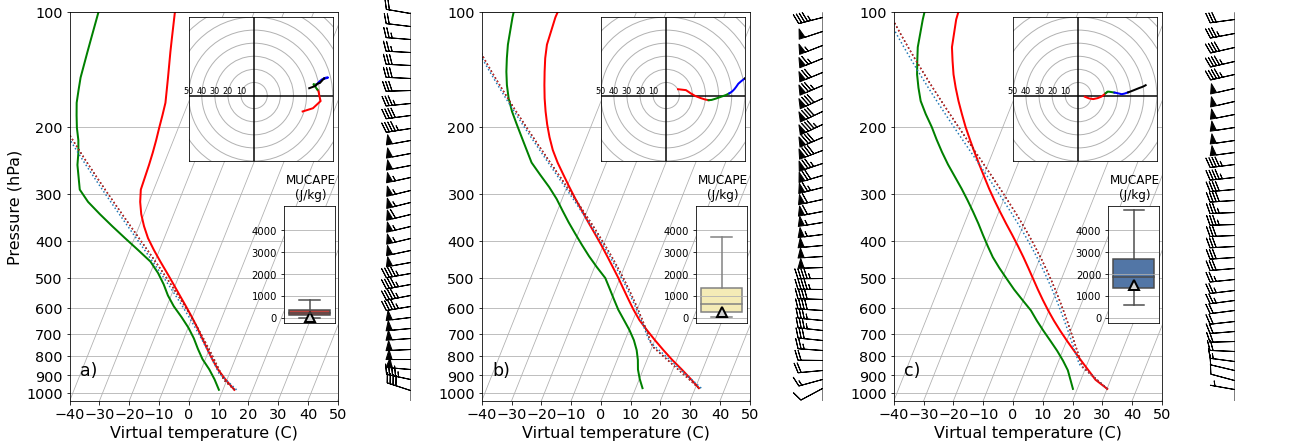

In [18]:
h_int = np.arange(250,17250,500)

plt.figure(figsize=[18,6])
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
inset_palette = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
gs = gridspec.GridSpec(1,6, width_ratios=[2,1,2,1,2,1])
letter = ["a)", "b)", "c)"]
cnt=0
for i in [1,2,0]:
    p_int = np.nanmean(np.stack([interp.pres(p,h_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)
    
    tmpc = np.nanmean(np.stack([interp.temp(p,p_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)
    pres = p_int
    dwpc = np.nanmean(np.stack([interp.dwpt(p,p_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)
    u = np.nanmean(np.stack([rotate_wind(p,p_int)[0] for p in np.array(profs)[cluster_index==i]]), axis=0)
    v = np.nanmean(np.stack([rotate_wind(p,p_int)[1] for p in np.array(profs)[cluster_index==i]]), axis=0)    
    prof = profile.create_profile(tmpc=tmpc, pres=p_int, hght=h_int, dwpc=dwpc, u=u, v=v, missing=np.nan)

    ax = plt.subplot(gs[0, 2*cnt], projection='skewx')

    ax2 = plt.subplot(gs[0, (2*cnt)+1])
    plot_prof(prof, ax, ax2, gs, hodo_size=2)
    ax.set_xlabel("Virtual temperature (C)",size=16)
    if cnt==0:
        ax.set_ylabel("Pressure (hPa)",size=16)    
    ax.text(-40, 900, letter[cnt], fontsize="xx-large")
    ax3=ax.inset_axes([0.8,0.2,0.19,0.3])
    sns.boxplot(y=[(p.bplus) for p in np.array(mupcls)[cluster_index==i]],ax=ax3,whis=1000,color=inset_palette[cnt])
    ax3.set_ylim([-250,5100])
    ax3.grid("y")
    ax3.set_yticks([0,1000,2000,3000,4000])
    ax3.set_xticks([])
    plt.text(0.90,0.52,"MUCAPE\n(J/kg)",size=12,ha="center",transform=ax.transAxes)
    ax3.plot(0, params.parcelx( prof, flag=3 ).bplus, color="lightgray", marker="^", mec="k", mew=2, ms=10)
    ax3.tick_params(labelsize=10)
    
    cnt=cnt+1

#Hodograph legend
#Red: 0-3 km
#Green: 3-6 km
#Blue: 6-9 km
#Black: 9-12 km
plt.subplots_adjust(bottom=0.4)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/sounding_composites.jpeg", dpi=500, bbox_inches="tight")

MUCAPE:  94.30398597059407 MLCAPE:  0.0 SBCAPE:  94.30398597059407 S06:  20.550072578859524 DCAPE 379.5244596258796
MUCAPE:  62.4380534003318 MLCAPE:  0.0 SBCAPE:  62.4380534003318 S06:  17.011033898608883 DCAPE 64.11584925935865
MUCAPE:  0.0 MLCAPE:  0.0 SBCAPE:  2.2240683536625765 S06:  18.409006126108604 DCAPE 80.29095881053097
MUCAPE:  0.0 MLCAPE:  0.0 SBCAPE:  0.0 S06:  8.019741069830886 DCAPE 155.72170539620925
MUCAPE:  0.0 MLCAPE:  0.0 SBCAPE:  1.8556651918699223 S06:  18.656053041083535 DCAPE 35.95207994713027
MUCAPE:  163.22676085522073 MLCAPE:  110.43657849081387 SBCAPE:  163.22676085522073 S06:  18.38193946210525 DCAPE 144.85037999507637


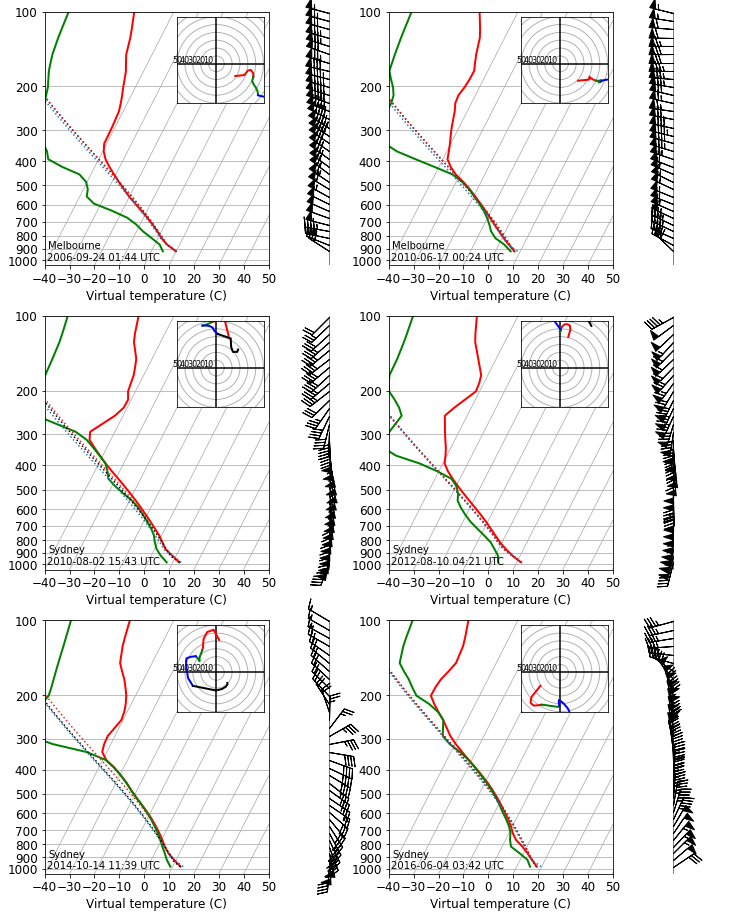

In [24]:
h_int = np.arange(250,17250,500)

plt.figure(figsize=[10,18])
plt.rcParams.update({'xtick.labelsize': 'large', 'ytick.labelsize': 'large'})
gs = gridspec.GridSpec(4,4, width_ratios=[2,1,2,1])

letter = ["a)", "b)", "c)"]
cnt=0
cnt2=0
i=1
temp_sounds = np.array(profs)[cluster_index==i]
temp_details = details_list.iloc[cluster_index==i]
for j in np.arange(len(temp_sounds)):
    p_int = np.nanmean(np.stack([interp.pres(p,h_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)    
    
    tmpc = interp.temp(temp_sounds[j],p_int).filled(np.nan)
    pres = p_int
    hght = interp.hght(temp_sounds[j],p_int).filled(np.nan)
    dwpc = interp.dwpt(temp_sounds[j],p_int).filled(np.nan)
    u = interp.components(temp_sounds[j],p_int)[0].filled(np.nan)    
    v = interp.components(temp_sounds[j],p_int)[1].filled(np.nan)    
    ind = np.where(~np.isnan(tmpc))[0]
    prof = profile.create_profile(tmpc=tmpc[ind], pres=np.array(pres)[ind], hght=hght[ind],
                                  dwpc=dwpc[ind], u=u[ind], v=v[ind], missing=np.nan)    

    ax = plt.subplot(gs[cnt2, 2*cnt], projection='skewx')
    ax2 = plt.subplot(gs[cnt2, (2*cnt)+1])
    plot_prof(prof, ax, ax2, gs, 1.2)
    
    if cnt == 1:
        cnt=0
        cnt2 = cnt2 + 1
    else:
        cnt=cnt+1
    ax.set_xlabel("Virtual temperature (C)",size=12)
    ax.text(-42,900,temp_details.iloc[j]["stn_name"],fontdict={"ha":"left"})
    ax.text(-40,1000,(temp_details.iloc[j]["gust_time_utc"].strftime("%Y-%m-%d %H:%M") + " UTC"),fontdict={"ha":"left"})    

plt.subplots_adjust(bottom=0.1)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/cluster1_soundings.jpeg", quality=100, bbox_inches="tight")

MUCAPE:  799.9925606327789 MLCAPE:  643.840650717637 SBCAPE:  799.9925606327789 S06:  17.613359064521674 DCAPE 520.5948389605815
MUCAPE:  1829.3835897785957 MLCAPE:  1166.7546265035862 SBCAPE:  1829.3835897785957 S06:  17.997460939395403 DCAPE 525.8743935584598
MUCAPE:  568.9238937121465 MLCAPE:  499.063053955825 SBCAPE:  568.9238937121465 S06:  13.926310928684064 DCAPE 435.8695573740842
MUCAPE:  736.3322158376625 MLCAPE:  633.8965108594127 SBCAPE:  614.6173043887497 S06:  9.106565803310275 DCAPE 202.2554676617482
MUCAPE:  1996.5536423112815 MLCAPE:  1717.1331028559318 SBCAPE:  1996.5536423112815 S06:  16.812133023887064 DCAPE 1050.4257766796811
MUCAPE:  1551.3666566157367 MLCAPE:  1152.0520500865564 SBCAPE:  1551.3666566157367 S06:  12.3038360152322 DCAPE 519.6598382827445
MUCAPE:  577.100603687368 MLCAPE:  288.80142400909585 SBCAPE:  577.100603687368 S06:  9.494622204929405 DCAPE 1205.6728429621612
MUCAPE:  2459.1948257697572 MLCAPE:  2376.4938980428524 SBCAPE:  2459.1948257697572 S0

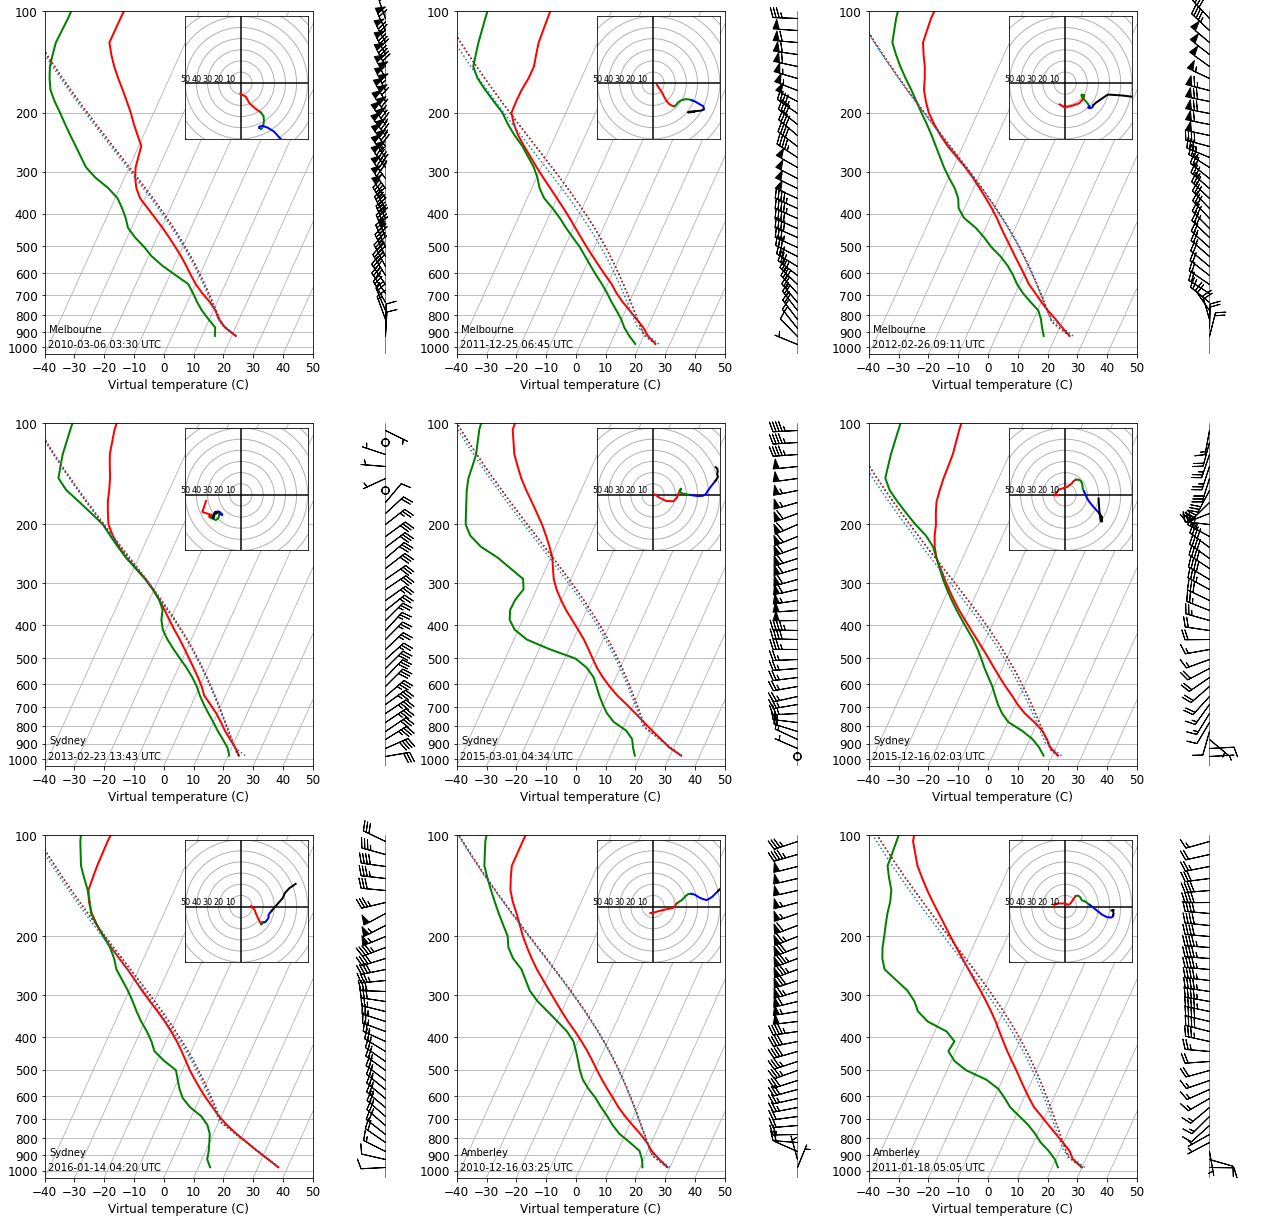

In [25]:
h_int = np.arange(250,17250,500)

plt.figure(figsize=[18,18])
plt.rcParams.update({'xtick.labelsize': 'large', 'ytick.labelsize': 'large'})
#gs = gridspec.GridSpec(4,12, width_ratios=[2,1,1,2,1,1,2,1,1,2,1,1])
gs = gridspec.GridSpec(3,6, width_ratios=[2,1,2,1,2,1])

letter = ["a)", "b)", "c)"]
cnt=0
cnt2=0
i=0
temp_sounds = np.array(profs)[cluster_index==i]
temp_details = details_list.iloc[cluster_index==i]
for j in np.arange(0,9):
    
        p_int = np.nanmean(np.stack([interp.pres(p,h_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)        

        tmpc = interp.temp(temp_sounds[j],p_int).filled(np.nan)
        pres = p_int
        hght = interp.hght(temp_sounds[j],p_int).filled(np.nan)
        dwpc = interp.dwpt(temp_sounds[j],p_int).filled(np.nan)
        u = interp.components(temp_sounds[j],p_int)[0].filled(np.nan)    
        v = interp.components(temp_sounds[j],p_int)[1].filled(np.nan)    
        ind = np.where(~np.isnan(tmpc))[0]
        prof = profile.create_profile(tmpc=tmpc[ind], pres=np.array(pres)[ind], hght=hght[ind],
                                      dwpc=dwpc[ind], u=u[ind], v=v[ind], missing=np.nan)    

        ax = plt.subplot(gs[cnt2, 2*cnt], projection='skewx')
        ax2 = plt.subplot(gs[cnt2, (2*cnt)+1])
        plot_prof(prof, ax, ax2, gs, 1.7)

        ax.set_xlabel("Virtual temperature (C)",size=12)
        ax.text(-42,900,temp_details.iloc[j]["stn_name"],fontdict={"ha":"left"})
        ax.text(-40,1000,(temp_details.iloc[j]["gust_time_utc"].strftime("%Y-%m-%d %H:%M") + " UTC"),fontdict={"ha":"left"})  

        if cnt == 2:
            cnt=0
            cnt2 = cnt2 + 1
        else:
            cnt=cnt+1    
    

plt.subplots_adjust(bottom=0.1)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/cluster3_soundings.jpeg", quality=100, bbox_inches="tight")


MUCAPE:  1351.5066071109352 MLCAPE:  1026.5024053773361 SBCAPE:  1351.5066071109352 S06:  23.566968615833336 DCAPE 728.8148355183143
MUCAPE:  1084.9408971707091 MLCAPE:  693.9467361957805 SBCAPE:  1084.9408971707091 S06:  19.91902559766932 DCAPE 888.4412959325772
MUCAPE:  871.1750882970646 MLCAPE:  489.3713358508924 SBCAPE:  871.1750882970646 S06:  23.696423771946932 DCAPE 390.886863518715
MUCAPE:  565.5438188747572 MLCAPE:  473.3262178610134 SBCAPE:  447.03018151382616 S06:  18.81902839322095 DCAPE 478.46496104621974
MUCAPE:  278.1494034035562 MLCAPE:  242.42592336472936 SBCAPE:  136.73266237402848 S06:  20.30750973675789 DCAPE 406.10446613594485
MUCAPE:  2622.555191482052 MLCAPE:  1132.3022802340156 SBCAPE:  2622.555191482052 S06:  18.341989205075638 DCAPE 512.2219485608371
MUCAPE:  3038.902249611017 MLCAPE:  1806.4413851838412 SBCAPE:  3038.902249611017 S06:  15.88554139313994 DCAPE 1055.4260722420213
MUCAPE:  1987.3588641718384 MLCAPE:  1543.232208534555 SBCAPE:  1987.3588641718384

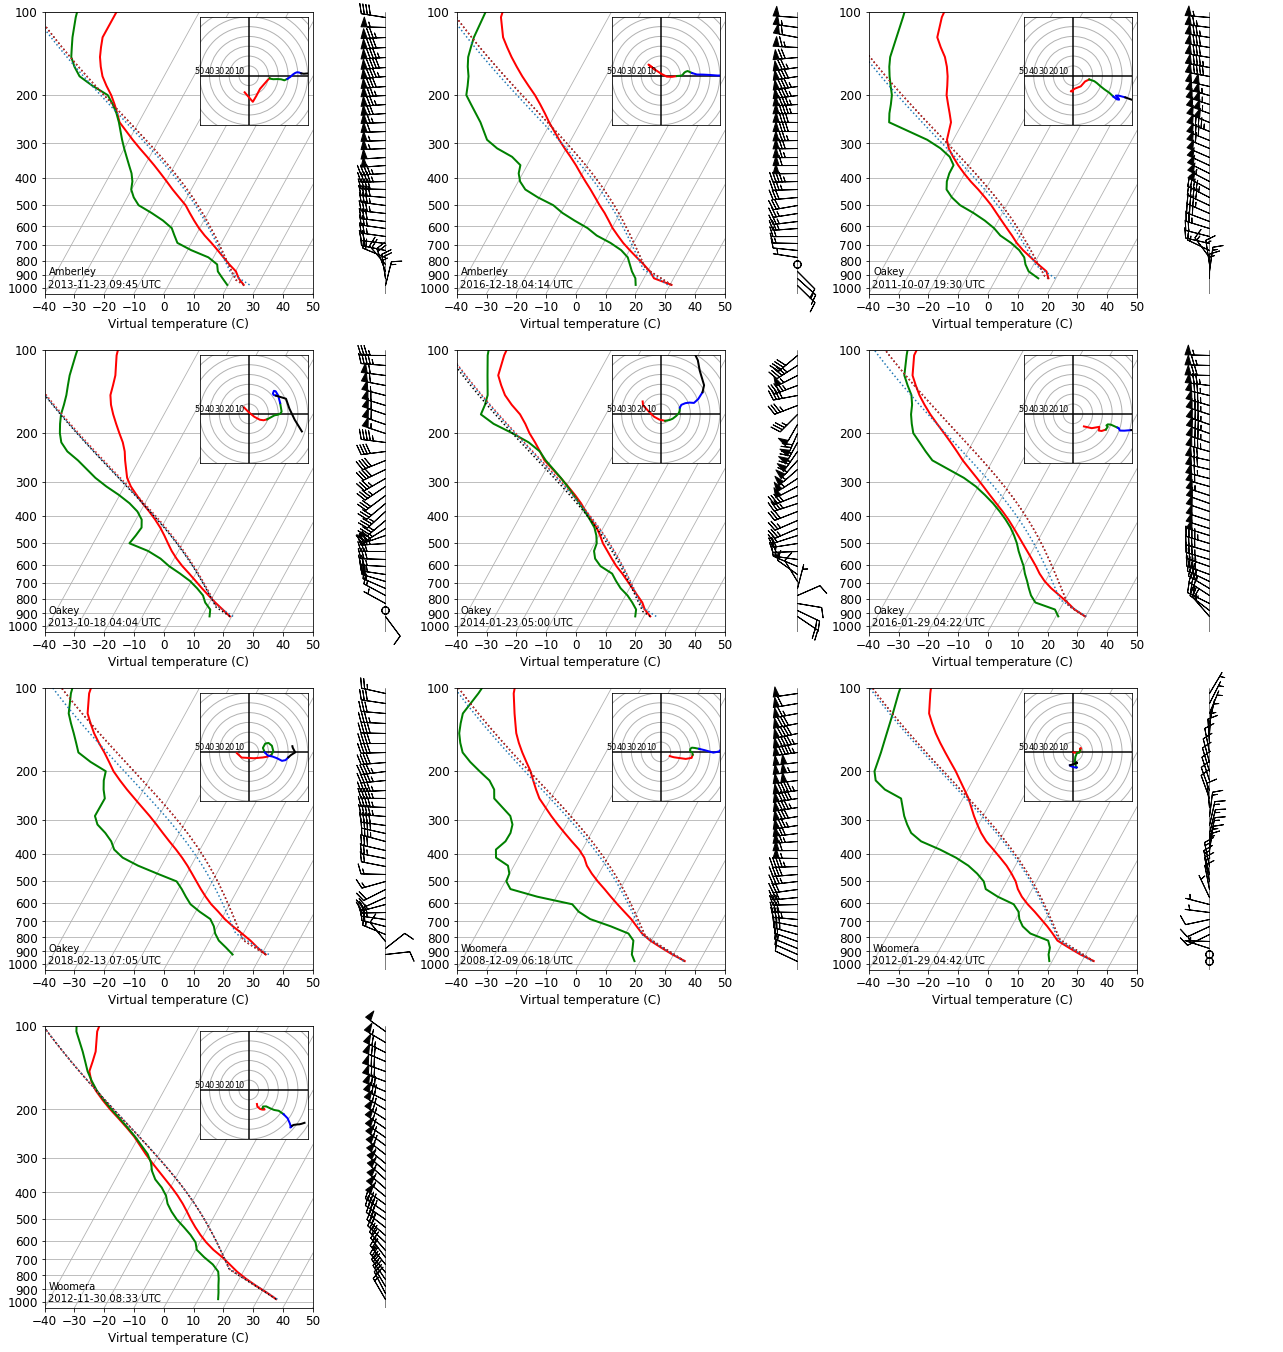

In [26]:
h_int = np.arange(250,17250,500)

plt.figure(figsize=[18,20])
plt.rcParams.update({'xtick.labelsize': 'large', 'ytick.labelsize': 'large'})
gs = gridspec.GridSpec(4,6, width_ratios=[2,1,2,1,2,1])

letter = ["a)", "b)", "c)"]
cnt=0
cnt2=0
i=0
temp_sounds = np.array(profs)[cluster_index==i]
temp_details = details_list.iloc[cluster_index==i]
for j in np.arange(9,19):
    
        p_int = np.nanmean(np.stack([interp.pres(p,h_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)        

        tmpc = interp.temp(temp_sounds[j],p_int).filled(np.nan)
        pres = p_int
        hght = interp.hght(temp_sounds[j],p_int).filled(np.nan)
        dwpc = interp.dwpt(temp_sounds[j],p_int).filled(np.nan)
        u = interp.components(temp_sounds[j],p_int)[0].filled(np.nan)    
        v = interp.components(temp_sounds[j],p_int)[1].filled(np.nan)    
        ind = np.where(~np.isnan(tmpc))[0]
        prof = profile.create_profile(tmpc=tmpc[ind], pres=np.array(pres)[ind], hght=hght[ind],
                                      dwpc=dwpc[ind], u=u[ind], v=v[ind], missing=np.nan)    

        ax = plt.subplot(gs[cnt2, 2*cnt], projection='skewx')
        ax2 = plt.subplot(gs[cnt2, (2*cnt)+1])
        plot_prof(prof, ax, ax2, gs, 1.5)

        ax.set_xlabel("Virtual temperature (C)",size=12)
        ax.text(-42,900,temp_details.iloc[j]["stn_name"],fontdict={"ha":"left"})
        ax.text(-40,1000,(temp_details.iloc[j]["gust_time_utc"].strftime("%Y-%m-%d %H:%M") + " UTC"),fontdict={"ha":"left"})  

        if cnt == 2:
            cnt=0
            cnt2 = cnt2 + 1
        else:
            cnt=cnt+1    
    

plt.subplots_adjust(bottom=0.1)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/cluster3_soundings_cont.jpeg", quality=100, bbox_inches="tight")


MUCAPE:  245.97220185332318 MLCAPE:  156.51872808587152 SBCAPE:  245.97220185332318 S06:  25.336549234121595 DCAPE 698.9551256342563
MUCAPE:  1467.828511294899 MLCAPE:  523.1862148831775 SBCAPE:  1467.828511294899 S06:  16.886588480675325 DCAPE 807.5244547858742
MUCAPE:  22.44361002271826 MLCAPE:  2.2866673372797877 SBCAPE:  22.44361002271826 S06:  31.869815051254914 DCAPE 604.2057182341641
MUCAPE:  754.8082773698139 MLCAPE:  645.0976594920817 SBCAPE:  754.8082773698139 S06:  32.2407508203215 DCAPE 537.41809462761
MUCAPE:  319.1587010777348 MLCAPE:  174.18817751019586 SBCAPE:  319.1587010777348 S06:  25.76170962221075 DCAPE 415.3378805627895
MUCAPE:  4.11250233389009 MLCAPE:  2.3808383141315437 SBCAPE:  0.0 S06:  22.666585331139107 DCAPE 1066.2916650577758
MUCAPE:  2275.183404007578 MLCAPE:  1008.0406782969752 SBCAPE:  2275.183404007578 S06:  15.857579329753943 DCAPE 864.1812305186276
MUCAPE:  643.3465724554046 MLCAPE:  304.41980622954884 SBCAPE:  643.3465724554046 S06:  28.78797106175

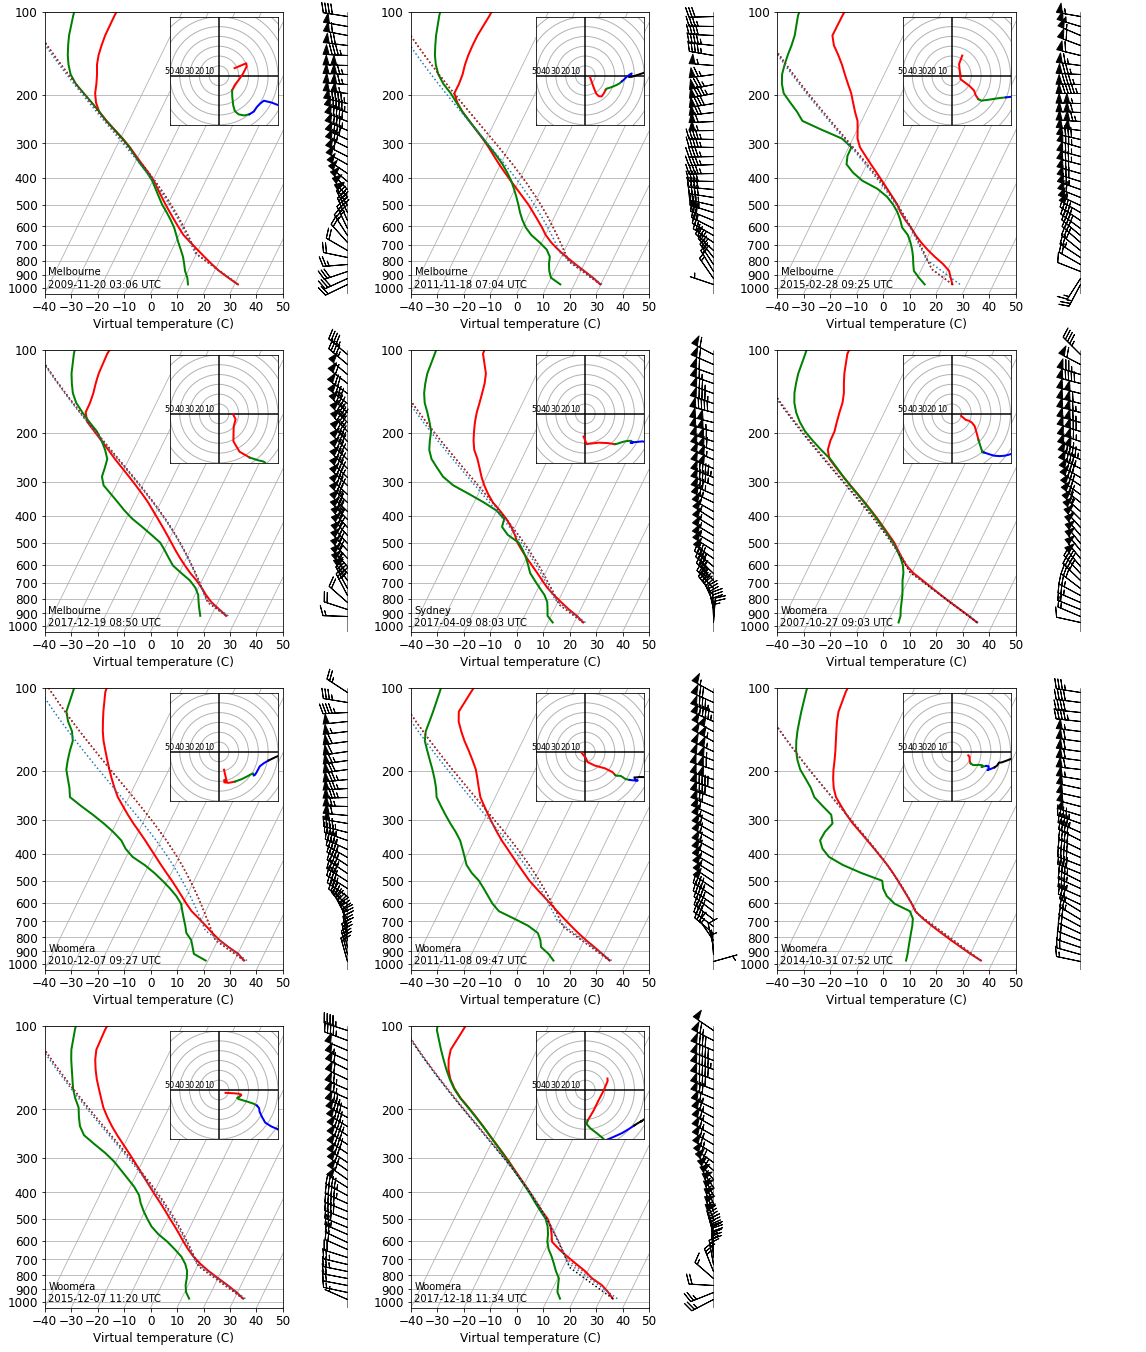

In [27]:
h_int = np.arange(250,17250,500)


plt.figure(figsize=[16,20])
plt.rcParams.update({'xtick.labelsize': 'large', 'ytick.labelsize': 'large'})
gs = gridspec.GridSpec(4,6, width_ratios=[2,1,2,1,2,1])

letter = ["a)", "b)", "c)"]
cnt=0
cnt2=0
i=2
temp_sounds = np.array(profs)[cluster_index==i]
temp_details = details_list.iloc[cluster_index==i]
for j in np.arange(len(temp_sounds)):
    p_int = np.nanmean(np.stack([interp.pres(p,h_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)        
    
    tmpc = interp.temp(temp_sounds[j],p_int).filled(np.nan)
    pres = p_int
    hght = interp.hght(temp_sounds[j],p_int).filled(np.nan)
    dwpc = interp.dwpt(temp_sounds[j],p_int).filled(np.nan)
    u = interp.components(temp_sounds[j],p_int)[0].filled(np.nan)    
    v = interp.components(temp_sounds[j],p_int)[1].filled(np.nan)    
    ind = np.where(~np.isnan(tmpc))[0]
    prof = profile.create_profile(tmpc=tmpc[ind], pres=np.array(pres)[ind], hght=hght[ind],
                                  dwpc=dwpc[ind], u=u[ind], v=v[ind], missing=np.nan)    

    ax = plt.subplot(gs[cnt2, 2*cnt], projection='skewx')
    ax2 = plt.subplot(gs[cnt2, (2*cnt)+1])
    inset_axes=plot_prof(prof, ax, ax2, gs, 1.5)
    
    if cnt == 2:
        cnt=0
        cnt2 = cnt2 + 1
    else:
        cnt=cnt+1
    ax.set_xlabel("Virtual temperature (C)",size=12)
    ax.text(-42,900,temp_details.iloc[j]["stn_name"],fontdict={"ha":"left"})
    ax.text(-40,1000,(temp_details.iloc[j]["gust_time_utc"].strftime("%Y-%m-%d %H:%M") + " UTC"),fontdict={"ha":"left"})  

plt.subplots_adjust(bottom=0.1)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/cluster2_soundings.jpeg", quality=100, bbox_inches="tight")

[1000.          774.26368268  599.48425032  464.15888336  359.38136638
  278.25594022  215.443469    166.81005372  129.1549665   100.        ] [-- 17.756881609699676 22.11850555467539 27.94857560993877
 33.14438578878303 42.57172165975395 50.28361171111515 47.96795591104872
 40.41423679271067 27.16883031692818] [-- -0.7306275987657087 2.8808247337546358 2.192840984260248
 1.0298601122601512 4.16011774358883 7.247514817642538 10.9637820756723
 9.278998693698421 2.9833906159903845]
[1000.          774.26368268  599.48425032  464.15888336  359.38136638
  278.25594022  215.443469    166.81005372  129.1549665   100.        ] [-- 26.179380633706486 38.167664740410515 48.442123246986434
 54.887532978265114 65.72815213787497 75.56664380215105 71.42158717094854
 56.38487563221629 38.92777564656082] [-- -1.8972785570402109 -2.2325377926772543 1.8744230903414276
 8.798310858318057 18.097874180966073 31.902890189466646
 32.684782288280935 22.731669559024727 9.358585620129007]
[1000.          774.2

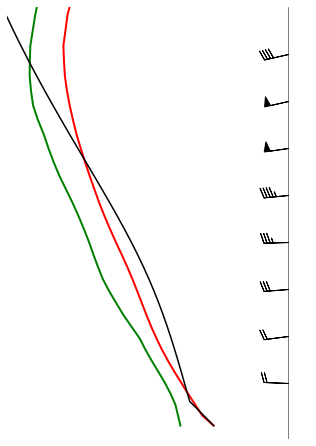

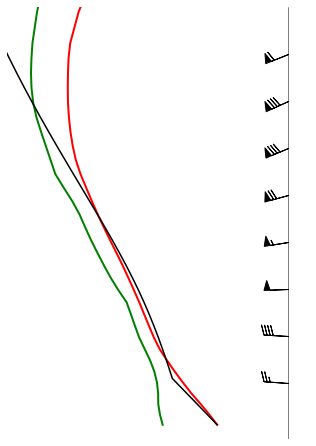

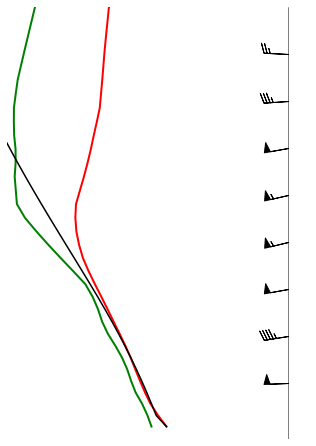

In [9]:
#Make some simplified plots

h_int = np.arange(250,17250,500)

cnt=0
for i in [0,2,1]:
    plt.figure(figsize=[6,10])
    ax=plt.axes([0.1,0.3,0.6,0.6],projection='skewx')
    ax2=plt.axes([0.7,0.3,0.1,0.6])

    p_int = np.nanmean(np.stack([interp.pres(p,h_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)
    
    tmpc = np.nanmean(np.stack([interp.temp(p,p_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)
    pres = p_int
    dwpc = np.nanmean(np.stack([interp.dwpt(p,p_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)
    u = np.nanmean(np.stack([rotate_wind(p,p_int)[0] for p in np.array(profs)[cluster_index==i]]), axis=0)
    v = np.nanmean(np.stack([rotate_wind(p,p_int)[1] for p in np.array(profs)[cluster_index==i]]), axis=0)    
    prof = profile.create_profile(tmpc=tmpc, pres=p_int, hght=h_int, dwpc=dwpc, u=u, v=v, missing=np.nan)

    plot_prof_simple(prof, ax, ax2)
    cnt=cnt+1

plt.subplots_adjust(bottom=0.4)
